# Проект 7. Ford vs Ferrari: определяем модель авто по фото

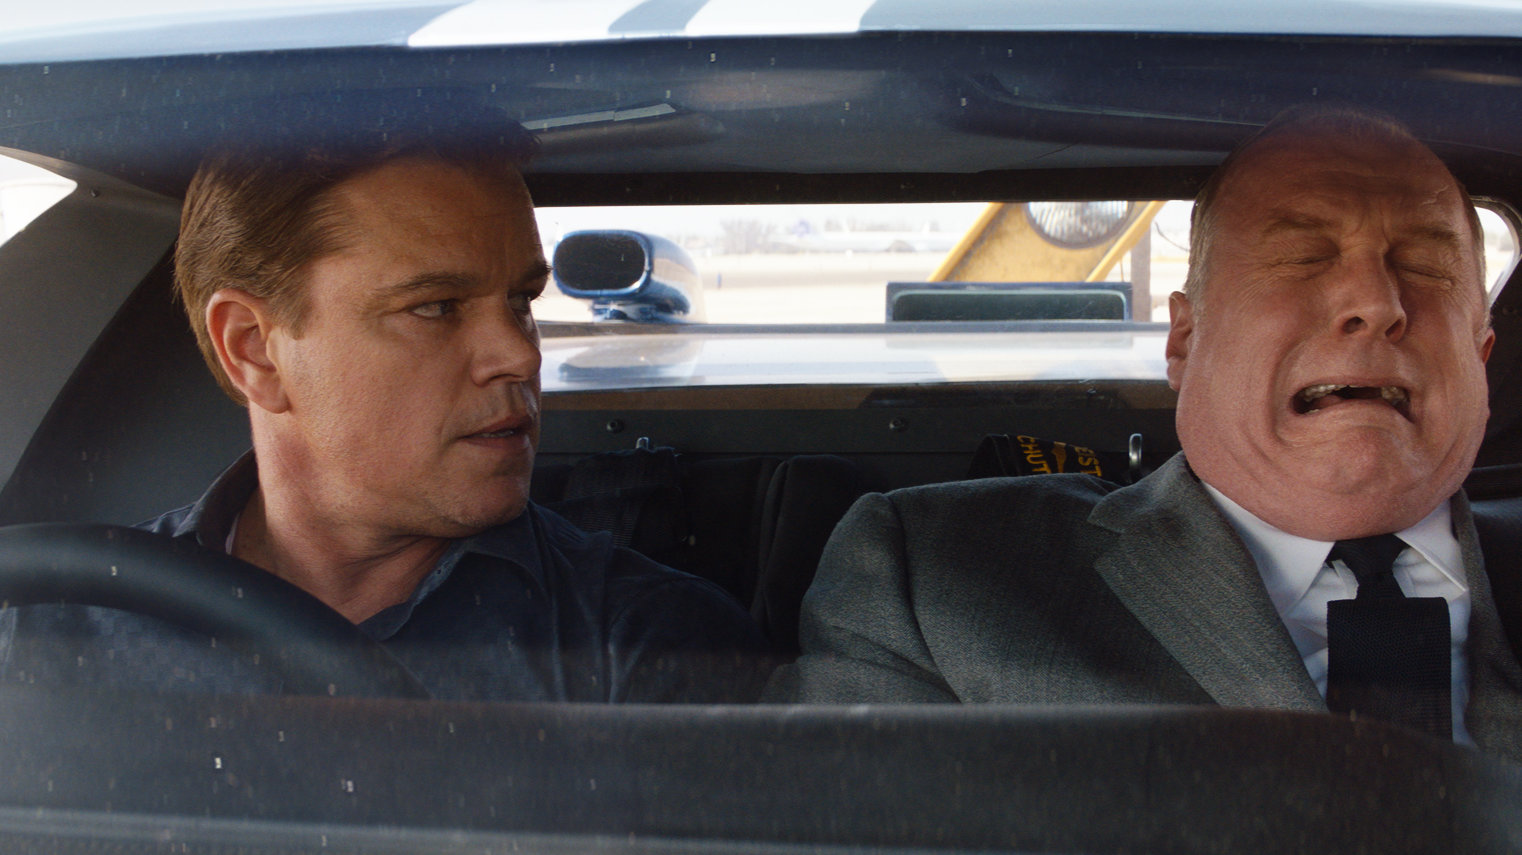

# Суть проекта — классификация автомобилей по их фотографиям.

# 1. Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import pickle
import zipfile
import csv
import sys
import os
import gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import tensorflow.keras.models as Model
import tensorflow.keras.layers as Layer

#from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

In [ ]:
# Обновление tensorflow
!pip install tensorflow --upgrade
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [ ]:
# сохраняем версии пакетов
!pip freeze > requirements.txt

# 2. Setup

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

RANDOM_SEED          = 42

EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sfcarclassif/'
PATH = "../working/" # рабочая директория

# 3. EDA

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

In [ ]:
train_df.info()

Нет пропусков.

In [ ]:
train_df.Category.value_counts()

Данные распределены равномерно

In [ ]:
train_df['Category'].nunique()

В датасете представлено 10 моделей машин

In [ ]:
print('Пример картинок')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_PATH+f'train/train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Картинки представлены разного размера

In [ ]:
#Посмотрим на примеры картинок и их размеры, чтобы понимать, как их лучше обрабатывать и сжимать.
image = PIL.Image.open(DATA_PATH+f'train/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

In [ ]:
#delete df no longer needed
del train_df
#collect residual garbage
gc.collect()

# 4. Аугментация данных

In [ ]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

In [ ]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224)],
        p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

# 5. Генерация данных

In [ ]:
train_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

train_datagen = train_gen.flow_from_directory(DATA_PATH+'train/train', 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            subset='training'
                                           )
test_datagen = train_gen.flow_from_directory(DATA_PATH+'train/train', 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                            )

In [ ]:
train_datagen.show_data(rows=3, cols=5)

# 6. Модель

Download pre-trained model

In [ ]:
# Загрузка модели efficientnet
!pip install -q efficientnet

In [ ]:
#from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.applications.inception_v3 import InceptionV3
import efficientnet.keras as efn 

In [ ]:
# Pre-trained model

#base_model = Xception(weights='imagenet', 
#                      include_top=False, 
#                      input_shape = input_shape)

#base_model = InceptionV3(weights='imagenet', 
#                         include_top=False, 
#                         input_shape = input_shape)

base_model = efn.EfficientNetB5(weights='imagenet', 
                                include_top=False, 
                                input_shape = input_shape)

#base_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=False)
#base_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)

In [ ]:
№base_model.summary()

In [ ]:
# freeze the pre-trained model weights, train only the top layers
base_model.trainable = False

In [ ]:
# Устанавливаем новую "голову" (head)

model=Model.Sequential()
model.add(base_model)
model.add(Layer.GlobalAveragePooling2D())
model.add(Layer.Dense(256, 
                      activation='relu', 
                      bias_regularizer=l2(1e-4),
                      activity_regularizer=l2(1e-5)))
model.add(Layer.BatchNormalization())
model.add(Layer.Dropout(0.5))
model.add(Layer.Dense(CLASS_NUM, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

# 7. Fit

In [ ]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1) 
# добавил EarlyStopping - прекращение обучения, 
# когда параметр monitor перестает улучшаться
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=1, min_lr=0.000001, verbose=1) 
# Уменьшение скорости обучения, 
# когда метрика перестала улучшаться

callbacks_list = [checkpoint,EarlyStopping,ReduceLROnPlateau]
# Рекомендация 1. Добавьте другие функции из https://keras.io/callbacks/
# Рекомендация 2. Используйте разные техники управления Learning Rate
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng)
# http://teleported.in/posts/cyclic-learning-rate/ (eng)

In [ ]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [ ]:
#model.save('../working/model_last.hdf5') 
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

## 7.1
### разморозка половины предварительно обученных весов модели

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
LR=0.0001
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [ ]:
#model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5') 

In [ ]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

## 7.2
### разморозка 3/4 предварительно обученных весов модели

In [ ]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
LR=0.00001

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [ ]:
#model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

## 7.2
### разморозка всех предварительно обученных весов модели

In [ ]:
base_model.trainable = True
LR=0.000001
#EPOCHS = 10

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [ ]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [ ]:
#model.save('../working/model_step4.hdf5') 
model.load_weights('best_model.hdf5') 

In [ ]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

# 8. Классификация после fine-tuning

In [ ]:
test_gen = ImageDataAugmentor(rescale=1./255)
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=DATA_PATH+'test/test_upload/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

In [ ]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, 
                                      steps=len(test_sub_generator), 
                                      verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')

submission.to_csv('submission.csv', index=False)

## 9. Увеличение размера изображения

In [ ]:
EPOCHS               = 6
BATCH_SIZE           = 2 
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [ ]:
AUGMENTATIONS = A.Compose([
    #A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.HorizontalFlip(p=0.5),
    #A.HueSaturationValue(p=0.5)
])

In [ ]:
train_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

train_datagen = train_gen.flow_from_directory(DATA_PATH+'train/train', 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            subset='training'
                                           )
test_datagen = train_gen.flow_from_directory(DATA_PATH+'train/train', 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                            )

test_gen = ImageDataAugmentor(rescale=1./255)
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=DATA_PATH+'test/test_upload/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

In [ ]:
base_model = efn.EfficientNetB5(weights='imagenet', 
                            include_top=False, 
                            input_shape = input_shape)

In [ ]:
base_model.trainable = True

In [ ]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])
model.load_weights('best_model.hdf5')

In [ ]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [ ]:
#!find /kaggle/working -name "*.hdf5" -type f -delete

In [ ]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

# 10. Классификация после увеличения изображения

In [ ]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')

In [ ]:
submission.to_csv('submission_IMG_SIZE.csv', index=False)

# 11. Test Time Augmentation (TTA)

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

In [ ]:
test_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                      directory=DATA_PATH+'test/test_upload',
                                      x_col="Id",
                                      y_col=None,
                                      target_size=(IMG_SIZE, IMG_SIZE),
                                      batch_size=BATCH_SIZE,
                                      class_mode=None,
                                      shuffle=False)

In [ ]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

In [ ]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')

In [ ]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
submission.to_csv('submission_TTA.csv', index=False)

# Итоги   

В результате работы удалось добиться показателя точности 0.97093 (48 место на Kaggle).
                    
В проекте применены:     
- transfer learning и fine-tuning (обучение головы -> 50% разморозка весов предобученной модели -> 75% разморозка -> 100% разморозка)
- дополнительные функции callback в Keras        
- настройка LR    
- настройка параметров регуляризации полносвязного слоя нейронной сети
- применена аугментация данных с использованием библиотеки аугментации изображений albumentations
- подобраны переменные (размер картинки, батч, количество эпох)
- добавлена Batch Normalization в архитектуре “головы” модели
- использованы различные архитектуры сетей
- добавлена TTA (Test Time Augmentation)
              

В рамках проекта пользовался подготовленным base_line, работами других участников соревнования, статьями по теме, а также информацией размещенной в документации к библиотекам. 

На данный момент не понятным осталось каким образом подбирать параметры аугментации данных (в одной Albumentations только 39 разных вариаций обработки изображения с различными показателями). 

Кроме того, насколько я понял, набор изображений imagenet содержит не так уж много фотографий авто (и довольно специфичных - спортивные и т.д.), при этом, мы используем модели обученные именно на этом наборе изображений. Почему? 

